In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

In [2]:
train = pd.read_csv('data/train_merged.csv', parse_dates=['date'], low_memory=False)
test = pd.read_csv('data/test_merged.csv', parse_dates=['date'], low_memory=False)

In [3]:
train.earthquake.fillna('', inplace=True)
train.event_name.fillna('', inplace=True)
train.national_holiday.fillna('', inplace=True)
train.regional_holiday.fillna('', inplace=True)
train.local_holiday.fillna('', inplace=True)

test.earthquake.fillna('', inplace=True)
test.event_name.fillna('', inplace=True)
test.national_holiday.fillna('', inplace=True)
test.regional_holiday.fillna('', inplace=True)
test.local_holiday.fillna('', inplace=True)

In [4]:
train.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,...,earthquake,event_name,national_holiday,regional_holiday,local_holiday,year,month,day,day_of_week,payday
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,...,,,Primer dia del ano,,,2013,1,1,1,False
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,...,,,Primer dia del ano,,,2013,1,1,1,False
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,...,,,Primer dia del ano,,,2013,1,1,1,False
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,...,,,Primer dia del ano,,,2013,1,1,1,False
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,...,,,Primer dia del ano,,,2013,1,1,1,False


In [5]:
test.head()

,id,date,store_nbr,family,onpromotion,city,state,type,cluster,transactions,...,earthquake,event_name,national_holiday,regional_holiday,local_holiday,year,month,day,day_of_week,payday
0,3000888,2017-08-16,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,NaN,...,,,,,,2017,8,16,2,False
1,3000889,2017-08-16,1,BABY CARE,0,Quito,Pichincha,D,13,NaN,...,,,,,,2017,8,16,2,False
2,3000890,2017-08-16,1,BEAUTY,2,Quito,Pichincha,D,13,NaN,...,,,,,,2017,8,16,2,False
3,3000891,2017-08-16,1,BEVERAGES,20,Quito,Pichincha,D,13,NaN,...,,,,,,2017,8,16,2,False
4,3000892,2017-08-16,1,BOOKS,0,Quito,Pichincha,D,13,NaN,...,,,,,,2017,8,16,2,False


In [6]:
%%time
cat_features = [
    'family', 'store_nbr', 'city', 'state', 'cluster',
    'earthquake', 'event_name', 'national_holiday', 'regional_holiday', 'local_holiday', 
    'payday', 'type',
]
for name in cat_features:
    print(f'Encode {name}')
    le = LabelEncoder()
    le.fit(train[name].unique())
    train[name] = le.transform(train[name])
    test[name] = le.transform(test[name])

Encode family
Encode store_nbr
Encode city
Encode state
Encode cluster
Encode earthquake
Encode event_name
Encode national_holiday
Encode regional_holiday
Encode local_holiday
Encode payday
Encode type
Wall time: 4.21 s


In [7]:
dates = sorted(train.date.unique())
border_date = dates[-30]
train_data = train[train.date <= border_date]
valid_data = train[train.date > border_date]

print(train_data.shape)
print(valid_data.shape)

(2949210, 22)
(51678, 22)


In [8]:
train_dates = train_data.date.unique()
valid_dates = valid_data.date.unique()
print(f'Train from {train_dates[0]} to {train_dates[-1]}')
print(f'Valid from {valid_dates[0]} to {valid_dates[-1]}')

Train from 2013-01-01T00:00:00.000000000 to 2017-07-17T00:00:00.000000000
Valid from 2017-07-18T00:00:00.000000000 to 2017-08-15T00:00:00.000000000


In [9]:
y_train = np.log(train_data[['sales']].values + 1)
y_valid = np.log(valid_data[['sales']].values + 1)

X_train = train_data.drop(['id', 'sales', 'year', 'date', 'transactions'], axis=1)
X_valid = valid_data.drop(['id', 'sales', 'year', 'date', 'transactions'], axis=1)

X_test = test.drop(['id', 'date', 'year', 'transactions'], axis=1)

In [10]:
X_test.head()

,store_nbr,family,onpromotion,city,state,type,cluster,oil_price,earthquake,event_name,national_holiday,regional_holiday,local_holiday,month,day,day_of_week,payday
0,0,0,0,18,12,3,12,46.8,0,0,0,0,0,8,16,2,0
1,0,1,0,18,12,3,12,46.8,0,0,0,0,0,8,16,2,0
2,0,2,2,18,12,3,12,46.8,0,0,0,0,0,8,16,2,0
3,0,3,20,18,12,3,12,46.8,0,0,0,0,0,8,16,2,0
4,0,4,0,18,12,3,12,46.8,0,0,0,0,0,8,16,2,0


In [139]:
xgb_params = {
    'gpu_id': 0,
    'tree_method': 'gpu_hist',
    'predictor': 'cpu_predictor',
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'random_state': 1,
    'learning_rate': 0.3,
    'subsample': 1,
    'max_depth': 7,
    'colsample_bytree': 1,
    'reg_alpha': 10,
    'reg_lambda': 1,
    'min_child_weight': 1,
}

In [140]:
%%time
xgb_train = xgb.DMatrix(X_train, label=y_train)
xgb_valid = xgb.DMatrix(X_valid, label=y_valid)
eval_list = [(xgb_train, 'train'), (xgb_valid, 'eval')]
eval_result = dict()

model = xgb.train(
    params=xgb_params,
    dtrain=xgb_train,
    evals=eval_list,
    evals_result=eval_result,
    num_boost_round=400,
    early_stopping_rounds=100,
)

[0]	train-rmse:2.74212	eval-rmse:2.90631
[1]	train-rmse:2.17220	eval-rmse:2.15826
[2]	train-rmse:1.80902	eval-rmse:1.67178
[3]	train-rmse:1.57790	eval-rmse:1.35955
[4]	train-rmse:1.43447	eval-rmse:1.17180
[5]	train-rmse:1.34411	eval-rmse:1.05793
[6]	train-rmse:1.26826	eval-rmse:0.97464
[7]	train-rmse:1.21874	eval-rmse:0.92517
[8]	train-rmse:1.19366	eval-rmse:0.89887
[9]	train-rmse:1.12446	eval-rmse:0.84995
[10]	train-rmse:1.07664	eval-rmse:0.81240
[11]	train-rmse:1.05113	eval-rmse:0.79913
[12]	train-rmse:1.02196	eval-rmse:0.78511
[13]	train-rmse:1.01191	eval-rmse:0.78157
[14]	train-rmse:0.98483	eval-rmse:0.77631
[15]	train-rmse:0.97250	eval-rmse:0.76380
[16]	train-rmse:0.94969	eval-rmse:0.74635
[17]	train-rmse:0.92829	eval-rmse:0.74095
[18]	train-rmse:0.91501	eval-rmse:0.72967
[19]	train-rmse:0.91063	eval-rmse:0.72818
[20]	train-rmse:0.89858	eval-rmse:0.72754
[21]	train-rmse:0.88522	eval-rmse:0.71757
[22]	train-rmse:0.87235	eval-rmse:0.71238
[23]	train-rmse:0.86933	eval-rmse:0.70876
[2

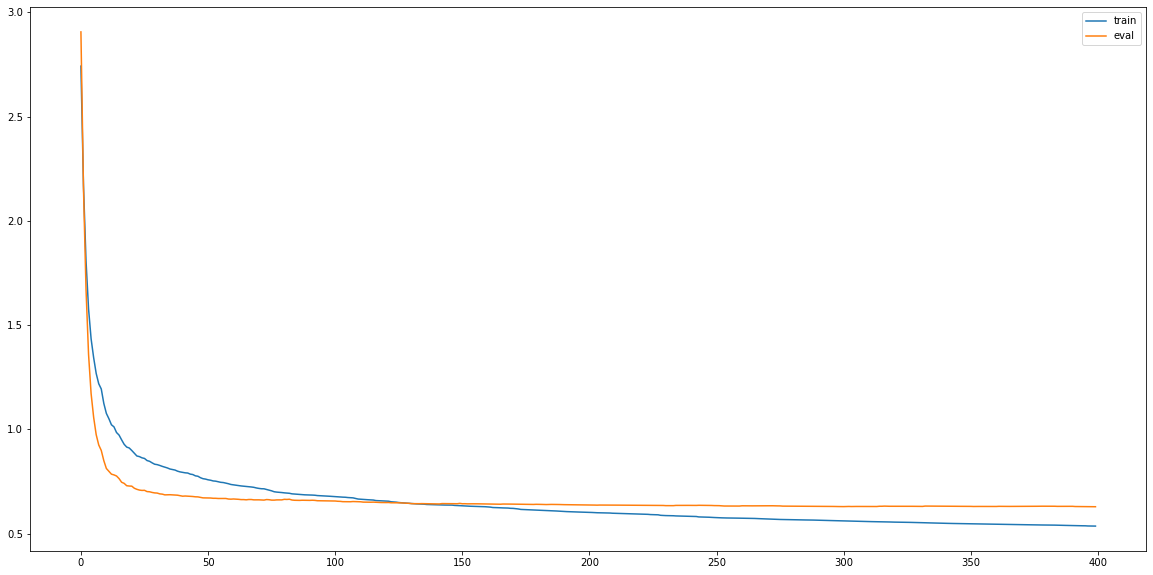

In [141]:
fig, ax = plt.subplots(figsize=(20, 10))
x = list(range(len(eval_result['eval']['rmse'])))
ax.plot(x, eval_result['train']['rmse'], label='train')
ax.plot(x, eval_result['eval']['rmse'], label='eval')
ax.legend(loc='upper right')
plt.show()

In [142]:
xgb_valid_pred = pd.Series(model.predict(xgb_valid)).map(lambda x: max(x, 0))
mean_squared_error(y_valid, xgb_valid_pred, squared=False)

0.621892929542391

In [143]:
sorted(model.get_fscore().items(), key=lambda x: x[1], reverse=True)

[('family', 14606),
 ('oil_price', 7333),
 ('store_nbr', 6841),
 ('month', 4396),
 ('cluster', 2393),
 ('onpromotion', 2303),
 ('day_of_week', 2086),
 ('city', 1946),
 ('day', 1794),
 ('type', 1724),
 ('state', 1401),
 ('national_holiday', 621),
 ('earthquake', 258),
 ('event_name', 179),
 ('payday', 69),
 ('local_holiday', 42),
 ('regional_holiday', 6)]

In [144]:
xgb_test = xgb.DMatrix(X_test)
xgb_pred = np.exp(pd.Series(model.predict(xgb_test)).map(lambda x: max(x, 0)))

In [145]:
pred = X_test.copy()
pred['sales'] = xgb_pred
pred.head()

,store_nbr,family,onpromotion,city,state,type,cluster,oil_price,earthquake,event_name,national_holiday,regional_holiday,local_holiday,month,day,day_of_week,payday,sales
0,0,0,0,18,12,3,12,46.8,0,0,0,0,0,8,16,2,0,4.518790
1,0,1,0,18,12,3,12,46.8,0,0,0,0,0,8,16,2,0,1.130015
2,0,2,2,18,12,3,12,46.8,0,0,0,0,0,8,16,2,0,6.207914
3,0,3,20,18,12,3,12,46.8,0,0,0,0,0,8,16,2,0,2393.371811
4,0,4,0,18,12,3,12,46.8,0,0,0,0,0,8,16,2,0,1.203442


In [146]:
for store_nbr in train.store_nbr.unique():
    for family in train.family.unique():
        cur_x = train[(train.store_nbr == store_nbr) & (train.family == family)]
        if not cur_x.sales.any():
            pred.loc[(pred.store_nbr == store_nbr) & (pred.family == family), 'sales'] = 0.0

In [147]:
sub = test[['id']].copy()
sub['sales'] = pred.sales
sub.head()

,id,sales
0,3000888,4.518790
1,3000889,0.000000
2,3000890,6.207914
3,3000891,2393.371811
4,3000892,1.203442


In [148]:
sub.to_csv('data/submission.csv', index=False)